Generate plots

In [1]:
import numpy as np
import pandas as pd
import pickle
import joypy
from pathlib import Path

from isttc.scripts.cfg_global import project_folder_path

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import seaborn as sns

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'

In [2]:
results_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau\\'
fig_folder = project_folder_path + 'results\\synthetic\\results\\param_fr_alpha_tau_abctau\\figs\\'

In [3]:
save_fig = False

### Load summary dataframes

ACF, iSTTC, PersonR, iSTTC trails (сoncat)

abcTau with oneTauOU and abcTau with oneTauOU_gammaSpikes

In [4]:
def long_to_wide(df, spec, index_cols=None, value_col="tau_diff_rel"):
    """
    Convert a long tau df to wide.

    spec: dict {new_column_name -> method_name_in_df}
          e.g. {"tau_diff_rel_acf": "acf_full", "tau_diff_rel_isttc": "isttc_full"}
    index_cols: columns that identify a unit 
    value_col: the value column to pivot (default: "tau_diff_rel")
    """
    if index_cols is None:
        index_cols = ["unit_id", "fr", "alpha", "lv", "tau_ms_true"]
    methods = list(spec.values())
    tmp = df.loc[df["method"].isin(methods),
                 index_cols + ["method", value_col]]
    wide = tmp.pivot(index=index_cols, columns="method", values=value_col)
    wide = wide.rename(columns={m: new for new, m in spec.items()})
    return wide.reset_index()

def inspect(df, name):
    print(f"len {name}: {len(df)}")
    print(df.columns.tolist())

results_folder = Path(results_folder)

# From summary_tau_all_long_df: four methods in one wide (ACF, iSTTC, PersonR, iSTTC trails (сoncat))
print('ACF, iSTTC, PersonR, iSTTC trails (сoncat)')
df_4_methods = pd.read_pickle(results_folder / "summary_tau_all_long_df_all_units.pkl")
df_abctau = pd.read_pickle(results_folder / "summary_tau_all_long_df_all_units_abctau.pkl")

inspect(df_4_methods, "df_4_methods (df_4_methods)")
inspect(df_abctau, "df_abctau (df_abctau)")

ACF, iSTTC, PersonR, iSTTC trails (сoncat)
len df_4_methods (df_4_methods): 400000
['unit_id', 'tau', 'tau_lower', 'tau_upper', 'fit_r_squared', 'acf_decline', 'method', 'tau_ms', 'fr', 'alpha', 'tau_ms_true', 'tau_diff_abs', 'tau_diff_rel', 'ci_width', 'lv']
len df_abctau (df_abctau): 2235
['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']


### Prepare extra dataframes for plotting 

In [5]:
df_4_methods_subset = df_4_methods[['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']].copy()
inspect(df_4_methods_subset, "df_4_methods_subset (df_4_methods_subset)")

df_abctau_subset = df_abctau.query('method == "abctau_run2_dst_gamma"').copy()
inspect(df_abctau_subset, "df_abctau_subset (df_abctau_subset)")

df_5_methods = pd.concat([df_4_methods_subset, df_abctau_subset])
df_5_methods.reset_index(inplace=True, drop=True)
inspect(df_5_methods, "df_5_methods (df_5_methods)")

len df_4_methods_subset (df_4_methods_subset): 400000
['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']
len df_abctau_subset (df_abctau_subset): 1421
['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']
len df_5_methods (df_5_methods): 401421
['unit_id', 'tau_ms', 'method', 'fr', 'alpha', 'tau_ms_true', 'lv', 'tau_diff_abs', 'tau_diff_rel']


In [6]:
# keep only unit_ids that have all methods present (5 here)
counts = df_5_methods.groupby('unit_id')['method'].nunique()
complete_units = counts[counts == df_5_methods['method'].nunique()].index
df_complete = df_5_methods[df_5_methods['unit_id'].isin(complete_units)].copy()

print(f"Remaining units: {len(complete_units)}")
print(f"Filtered DataFrame shape: {df_complete.shape}")

Remaining units: 1421
Filtered DataFrame shape: (7105, 9)


In [7]:
# Dataframe to plot now many spike trains for a method have a REE within certain percentage
intervals = {
    '+-100':   (0,   100),
    '+-75':  (0,  75),
    '+-50':  (0,  50),
    '+-25':  (0,  25),
}

df = df_complete.copy()

rows = []
for method, sub in df.groupby('method'):
    total = len(sub)
    row = {'method': method}
    for name, (lo, hi) in intervals.items():
        cnt = sub['tau_diff_rel'].between(lo, hi).sum()
        row[name] = cnt/total*100
    rows.append(row)
tau_plot_error_df = pd.DataFrame(rows).set_index('method')

# make long df
tau_plot_error_df = tau_plot_error_df.reset_index()
tau_plot_error_long_df = tau_plot_error_df.melt(
    id_vars='method',
    var_name='interval',
    value_name='percentage'
)
tau_plot_error_long_df

,method,interval,percentage
0,abctau_run2_dst_gamma,+-100,84.588318
1,acf_full,+-100,97.466573
2,isttc_full,+-100,96.903589
3,pearsonr_trial_avg,+-100,66.220971
4,sttc_trial_concat,+-100,78.676988
5,abctau_run2_dst_gamma,+-75,78.606615
6,acf_full,+-75,94.933146
7,isttc_full,+-75,94.933146
8,pearsonr_trial_avg,+-75,50.879662
9,sttc_trial_concat,+-75,57.705841


In [8]:
# get percentage of units with tau_ms in 100% error range
mask = df_complete['tau_diff_rel'].between(0, 100)
tau_plot_long_0_100perc_df = (
    df_complete
    .groupby('method')
    .agg(
        total       = ('tau_diff_rel', 'size'),
        in_range    = ('tau_diff_rel', lambda x: x.between(0,100).sum())
    )
)
tau_plot_long_0_100perc_df['percent_in_range'] = tau_plot_long_0_100perc_df['in_range'] / tau_plot_long_0_100perc_df['total'] * 100
tau_plot_long_0_100perc_df = tau_plot_long_0_100perc_df.assign(
    percent_in_range=lambda d: d['percent_in_range'].map("{:.1f}%".format)
)
tau_plot_long_0_100perc_df

,total,in_range,percent_in_range
method,,,
abctau_run2_dst_gamma,1421,1202,84.6%
acf_full,1421,1385,97.5%
isttc_full,1421,1377,96.9%
pearsonr_trial_avg,1421,941,66.2%
sttc_trial_concat,1421,1118,78.7%


### Plots

In [9]:
color_acf_full = '#718190'
color_isttc_full = '#1ba9e2' 
color_pearson_trail_avg = '#f4a91c' 
color_sttc_trail_avg =  '#a49fce' 
color_sttc_trail_concat = '#955da2' 
color_abctau = '#B4464B'

colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat, color_abctau]

In [10]:
def plot_one_threshold_jittered_lines(ax, df, jitter=0.15, seed=None, plot_lines=False):
    if seed is not None:
        np.random.seed(seed)

    methods = [
        ("pearsonr_trial_avg", color_pearson_trail_avg, "pearsonr_avg"),
        ("sttc_trial_concat",  color_sttc_trail_concat,  "sttc_concat"),
        #("abctau_run1_ou",     color_abctau_ou,     "abctau_run1_ou"),
        ("abctau_run2_dst_gamma",     color_abctau,     "abctau_run2_dst_gamma"),
        ("acf_full",           color_acf_full,           "acf_full"),
        ("isttc_full",         color_isttc_full,         "isttc_full"),
    ]

    # fixed ordering of intervals
    cats = list(df["interval"].unique())
    idx_map = {cat:i for i,cat in enumerate(cats)}

    for method, col, label in methods:
        sub = df[df["method"] == method]
        # map string-labels to integer indices
        x0 = np.array([idx_map[s] for s in sub["interval"]])
        y  = sub["percentage"].values

        #  one jitter per point
        offsets = np.random.uniform(-jitter, jitter, size=len(x0))
        xj = x0 + offsets

        if plot_lines:
            order = np.argsort(x0)
            ax.plot(xj[order], y[order],
                    color=col,
                    linewidth=0.8,
                    alpha=1)
        # plot jittered points
        ax.scatter(xj, y,
                   color=col,
                   s=40,
                   marker="o",
                   label=label)

    ax.set_xticks(np.arange(len(cats)))
    ax.set_xticklabels(cats)

def hexbin_pair(
    df, *,
    x1, x2, y,
    c,                            # 1D array/Series with same index as df
    title,
    xlabel1, xlabel2, ylabel,
    xticks2=None, yticks=None,         
    ylim=None,
    gridsize=10,
    cmap="RdBu_r",
    vcenter=0,
    mincnt=1,
    save_path_png=None,           # full path or None
    save_path_svg=None,           # full path or None
):
    """Two-panel hexbin with the SAME symmetric color scale based on 95th pct."""
    fig, axes = plt.subplots(1, 2, figsize=(8, 2.5))
    norm = TwoSlopeNorm(vcenter=vcenter)

    hb0 = axes[0].hexbin(
        x=df[x1], y=df[y], C=c,
        reduce_C_function=np.median, gridsize=gridsize,
        cmap=cmap, norm=norm, mincnt=mincnt
    )
    hb1 = axes[1].hexbin(
        x=df[x2], y=df[y], C=c,
        reduce_C_function=np.median, gridsize=gridsize,
        cmap=cmap, norm=norm, mincnt=mincnt
    )

    # Symmetric colorbar limits from both panels (95th percentile of |values|)
    arr = np.hstack([hb0.get_array(), hb1.get_array()])
    bar_lim = np.percentile(np.abs(arr), 95)
    hb0.set_clim(-bar_lim, bar_lim)
    hb1.set_clim(-bar_lim, bar_lim)

    fig.colorbar(hb0, ax=axes[0], shrink=1)
    fig.colorbar(hb1, ax=axes[1], shrink=1)

    axes[0].set_xlabel(xlabel1)
    axes[1].set_xlabel(xlabel2)
    if xticks2 is not None:
        axes[1].set_xticks(xticks2)

    fig.suptitle(title, y=1.05)

    for ax in axes.flat:
        sns.despine(ax=ax)
        ax.set_ylabel(ylabel)
        if ylim is not None:
            ax.set_ylim(ylim)
        if yticks is not None:
            ax.set_yticks(yticks)

    if save_path_png:
        fig.savefig(save_path_png, bbox_inches="tight", dpi=300)
    if save_path_svg:
        fig.savefig(save_path_svg, bbox_inches="tight")

    return fig, axes

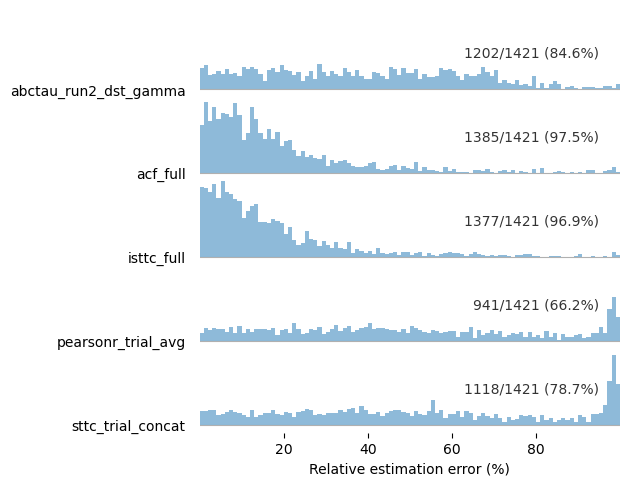

In [11]:
fig, axes = joypy.joyplot(data=df_complete.query('tau_diff_rel >= 0 and tau_diff_rel <= 100'),
    by='method',
    column='tau_diff_rel',
    #range_style='own',
    ylim = 'max',
    grid="y",
    #kind='kde',
    hist=True, bins=100, fill=False,
    overlap=0.1,
    alpha=0.5,
    linewidth=1,
    x_range=[0,100]
)

#axes[-1].axvline(x=100, color='k', lw=0.5)

axes[-1].set_xlabel('Relative estimation error (%)')
#fig.suptitle('1000ms trials (n=40) vs full signal, tau = 100ms', y=1.05)


method_order = [
    #'abctau_run1_ou',
    'abctau_run2_dst_gamma',
    'acf_full',
    'isttc_full',
    'pearsonr_trial_avg',
    'sttc_trial_concat',
]
for ax, method in zip(axes, method_order):
    tot    = tau_plot_long_0_100perc_df.at[method, 'total']
    inn    = tau_plot_long_0_100perc_df.at[method, 'in_range']
    pct    = tau_plot_long_0_100perc_df.at[method, 'percent_in_range']
    txt    = f"{inn}/{tot} ({pct})"
    # place in axis‐relative coords (x=95% from left, y=center)
    ax.text(
        0.95, 0.5, txt,
        transform = ax.transAxes,
        ha        = 'right',
        va        = 'center',
        fontsize  = 10,
        alpha     = 0.8
    )

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_run2_dst_gamma_one_trial_impl_rel_error_hist.png' , bbox_inches='tight', dpi=300)
    #plt.savefig(fig_folder + 'parametric_abctau_run2_dst_gamma_one_trial_impl_rel_error_hist.svg' , bbox_inches='tight')

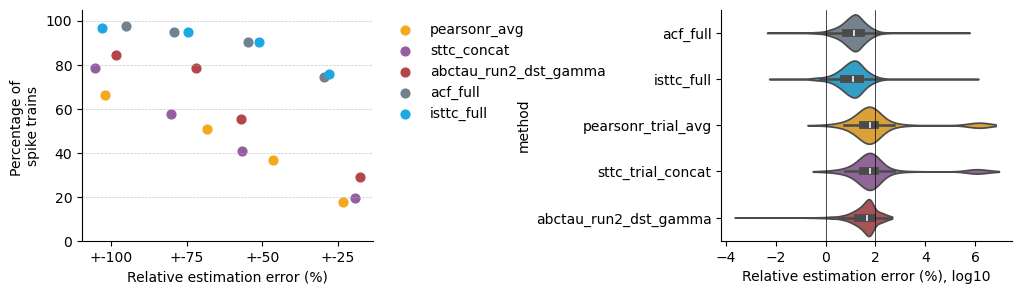

In [12]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

plot_one_threshold_jittered_lines(axes[0],
    tau_plot_error_long_df,
    jitter=0.3, seed=42)
axes[0].set_ylabel('Percentage of \nspike trains')
axes[0].set_xlabel('Relative estimation error (%)')
axes[0].set_ylim([0, 105])
axes[0].grid(True, which="both", axis='y', linestyle="--", linewidth=0.5, alpha=0.7)

df_complete['tau_diff_rel_log10'] = np.log10(df_complete['tau_diff_rel'])
method_order = ['acf_full', 'isttc_full', 'pearsonr_trial_avg', 'sttc_trial_concat', 'abctau_run2_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               palette=colors, data=df_complete , cut=0, ax=axes[1])
axes[1].axvline(x=0, lw=0.5, c='k')
axes[1].axvline(x=2, lw=0.5, c='k')
axes[1].set_xlabel('Relative estimation error (%), log10')

for ax in axes.flat:
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_run2_dst_gamma_taus_rel_error_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    #plt.savefig(fig_folder + 'parametric_abctau_run2_dst_gamma_taus_rel_error_one_trials_impl.svg' , bbox_inches='tight')

In [ ]:
df_complete 

#colors = [color_acf_full, color_isttc_full, color_pearson_trail_avg, color_sttc_trail_concat, color_abctau]

In [13]:
df_complete['method'].unique()

array(['acf_full', 'isttc_full', 'pearsonr_trial_avg',
       'sttc_trial_concat', 'abctau_run2_dst_gamma'], dtype=object)

In [14]:
df_complete_trials = df_complete[df_complete['method'].isin(['pearsonr_trial_avg','sttc_trial_concat', 'abctau_run2_dst_gamma'])]
df_complete_trials

,unit_id,tau_ms,method,fr,alpha,tau_ms_true,lv,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10
200000,0,252.749919,pearsonr_trial_avg,7.741821,0.851099,150.923515,1.307775,101.826404,67.468879,1.829103
200001,1,101.021800,pearsonr_trial_avg,4.394396,0.858098,147.947233,1.345006,46.925433,31.717682,1.501301
200002,2,3999.934263,pearsonr_trial_avg,8.587393,0.528805,267.002290,1.068416,3732.931973,1398.089874,3.145535
200003,3,548.658840,pearsonr_trial_avg,6.976707,0.300692,194.403797,1.055631,354.255043,182.226402,2.260611
200004,4,94.195485,pearsonr_trial_avg,0.950832,0.691458,239.986489,1.357205,145.791004,60.749672,1.783544
...,...,...,...,...,...,...,...,...,...,...
401416,1590,232.422715,abctau_run2_dst_gamma,1.959903,0.481223,230.171867,1.350346,2.250848,0.977899,-0.009706
401417,1591,247.094549,abctau_run2_dst_gamma,0.588874,0.317444,213.688575,1.440447,33.405974,15.633018,1.194043
401418,1592,234.739575,abctau_run2_dst_gamma,9.493442,0.345019,72.046806,1.140615,162.692769,225.815381,2.353754
401419,1593,118.249577,abctau_run2_dst_gamma,4.034767,0.554841,180.121551,1.276545,61.871974,34.350123,1.535928


In [ ]:
df_complete.keys()

In [15]:
df_best = df_complete.loc[df_complete.groupby('unit_id')['tau_diff_rel'].idxmin()].reset_index(drop=True)
df_best

,unit_id,tau_ms,method,fr,alpha,tau_ms_true,lv,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10
0,0,126.170618,isttc_full,7.741821,0.851099,150.923515,1.307775,24.752897,16.400954,1.214869
1,1,141.716309,isttc_full,4.394396,0.858098,147.947233,1.345006,6.230924,4.211585,0.624446
2,2,261.372568,acf_full,8.587393,0.528805,267.002290,1.068416,5.629722,2.108492,0.323972
3,3,197.510466,acf_full,6.976707,0.300692,194.403797,1.055631,3.106670,1.598050,0.203590
4,4,230.491166,isttc_full,0.950832,0.691458,239.986489,1.357205,9.495323,3.956607,0.597323
...,...,...,...,...,...,...,...,...,...,...
1416,1590,232.422715,abctau_run2_dst_gamma,1.959903,0.481223,230.171867,1.350346,2.250848,0.977899,-0.009706
1417,1591,247.094549,abctau_run2_dst_gamma,0.588874,0.317444,213.688575,1.440447,33.405974,15.633018,1.194043
1418,1592,60.186812,acf_full,9.493442,0.345019,72.046806,1.140615,11.859994,16.461512,1.216470
1419,1593,158.100300,acf_full,4.034767,0.554841,180.121551,1.276545,22.021251,12.225772,1.087276


In [16]:
df_best.groupby(by='method').count()

,unit_id,tau_ms,fr,alpha,tau_ms_true,lv,tau_diff_abs,tau_diff_rel,tau_diff_rel_log10
method,,,,,,,,,
abctau_run2_dst_gamma,238,238,238,238,238,238,238,238,238
acf_full,465,465,465,465,465,465,465,465,465
isttc_full,553,553,553,553,553,553,553,553,553
pearsonr_trial_avg,77,77,77,77,77,77,77,77,77
sttc_trial_concat,88,88,88,88,88,88,88,88,88


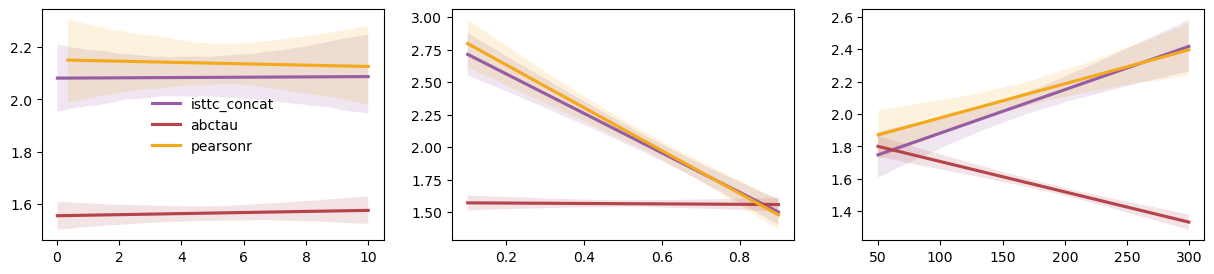

In [17]:
# regplot

fig, axes = plt.subplots(1,3, figsize=(15, 3), sharey=False)

sns.regplot(x=df_complete[df_complete['method'] == "sttc_trial_concat"]['fr'].values, 
            y=df_complete[df_complete['method'] == "sttc_trial_concat"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[0], 
            label='isttc_concat', color=color_sttc_trail_concat)


sns.regplot(x=df_complete[df_complete['method'] == "abctau_run2_dst_gamma"]['fr'].values, 
            y=df_complete[df_complete['method'] == "abctau_run2_dst_gamma"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[0], 
            label='abctau', color=color_abctau)


sns.regplot(x=df_complete[df_complete['method'] == "pearsonr_trial_avg"]['fr'].values, 
            y=df_complete[df_complete['method'] == "pearsonr_trial_avg"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[0], 
            label='pearsonr', color=color_pearson_trail_avg)


sns.regplot(x=df_complete[df_complete['method'] == "sttc_trial_concat"]['alpha'].values, 
            y=df_complete[df_complete['method'] == "sttc_trial_concat"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[1], 
            label='isttc_concat', color=color_sttc_trail_concat)


sns.regplot(x=df_complete[df_complete['method'] == "abctau_run2_dst_gamma"]['alpha'].values, 
            y=df_complete[df_complete['method'] == "abctau_run2_dst_gamma"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[1], 
            label='abctau', color=color_abctau)


sns.regplot(x=df_complete[df_complete['method'] == "pearsonr_trial_avg"]['alpha'].values, 
            y=df_complete[df_complete['method'] == "pearsonr_trial_avg"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[1], 
            label='pearsonr', color=color_pearson_trail_avg)


sns.regplot(x=df_complete[df_complete['method'] == "sttc_trial_concat"]['tau_ms_true'].values, 
            y=df_complete[df_complete['method'] == "sttc_trial_concat"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[2], 
            label='isttc_concat', color=color_sttc_trail_concat)


sns.regplot(x=df_complete[df_complete['method'] == "abctau_run2_dst_gamma"]['tau_ms_true'].values, 
            y=df_complete[df_complete['method'] == "abctau_run2_dst_gamma"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[2], 
            label='abctau', color=color_abctau)


sns.regplot(x=df_complete[df_complete['method'] == "pearsonr_trial_avg"]['tau_ms_true'].values, 
            y=df_complete[df_complete['method'] == "pearsonr_trial_avg"]['tau_diff_rel_log10'].values, 
            scatter=None, ax=axes[2], 
            label='pearsonr', color=color_pearson_trail_avg)

axes[0].legend(frameon=False)

### Compare abcTau runs

In [18]:
df_abctau

,unit_id,tau_ms,method,fr,alpha,tau_ms_true,lv,tau_diff_abs,tau_diff_rel
0,1303,282.787084,abctau_run1_ou,2.581649,0.858982,172.572553,1.327349,110.214531,63.865620
1,0,95.733949,abctau_run1_ou,7.741821,0.851099,150.923515,1.307775,55.189566,36.567904
2,1,93.162482,abctau_run1_ou,4.394396,0.858098,147.947233,1.345006,54.784751,37.029926
3,2,3.776298,abctau_run1_ou,8.587393,0.528805,267.002290,1.068416,263.225991,98.585668
4,3,6.976921,abctau_run1_ou,6.976707,0.300692,194.403797,1.055631,187.426875,96.411119
...,...,...,...,...,...,...,...,...,...
2230,25,62.884586,abctau_run4_dst_gamma,1.954441,0.105302,105.941584,1.108131,43.056999,40.642208
2231,26,78.616317,abctau_run4_dst_gamma,4.672543,0.755882,230.484702,1.292114,151.868384,65.890874
2232,27,58.995286,abctau_run4_dst_gamma,0.447600,0.846573,103.016279,1.775889,44.020993,42.732074
2233,28,62.608460,abctau_run4_dst_gamma,1.551352,0.869480,290.790300,1.360630,228.181840,78.469550


C:\Users\ipochino\AppData\Local\Temp\ipykernel_18608\1583460564.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))
C:\Users\ipochino\AppData\Local\Temp\ipykernel_18608\1583460564.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(labels_with_n)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_18608\1583460564.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(labels_with_n)


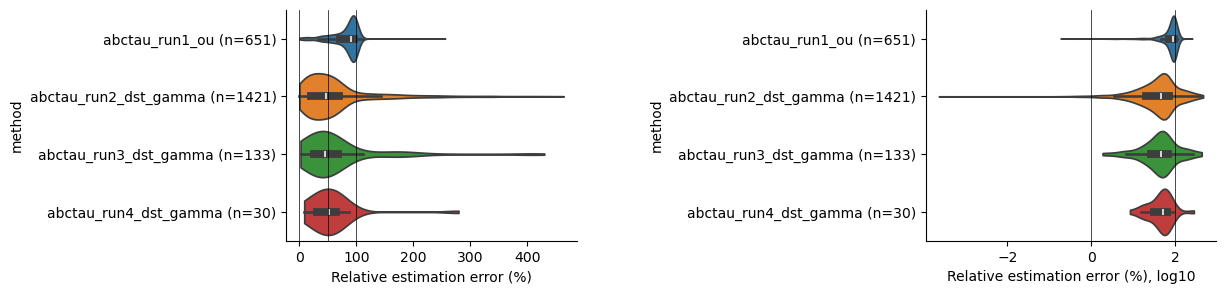

In [19]:
fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

method_order = ['abctau_run1_ou', 'abctau_run2_dst_gamma', 'abctau_run3_dst_gamma','abctau_run4_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau , cut=0, ax=axes[0])
axes[0].axvline(x=0, lw=0.5, c='k')
axes[0].axvline(x=50, lw=0.5, c='k')
axes[0].axvline(x=100, lw=0.5, c='k')
axes[0].set_xlabel('Relative estimation error (%)')

df_abctau['tau_diff_rel_log10'] = np.log10(df_abctau['tau_diff_rel'])
method_order = ['abctau_run1_ou', 'abctau_run2_dst_gamma', 'abctau_run3_dst_gamma','abctau_run4_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau , cut=0, ax=axes[1])
axes[1].axvline(x=0, lw=0.5, c='k')
axes[1].axvline(x=2, lw=0.5, c='k')
axes[1].set_xlabel('Relative estimation error (%), log10')

for ax in axes.flat:
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))

# counts per method (unique units)
counts = (
    df_abctau.groupby('method')['unit_id']
    .nunique()
    .reindex(method_order)       
    .fillna(0).astype(int)
)
labels_with_n = [f"{m} (n={counts.get(m, 0)})" for m in method_order]
axes[0].set_yticklabels(labels_with_n)
axes[1].set_yticklabels(labels_with_n)

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl.png' , bbox_inches='tight', dpi=300)
    #plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl.svg' , bbox_inches='tight')

Remaining units: 30
Filtered DataFrame shape: (120, 10)


C:\Users\ipochino\AppData\Local\Temp\ipykernel_18608\4218156684.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))
C:\Users\ipochino\AppData\Local\Temp\ipykernel_18608\4218156684.py:41: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(labels_with_n)
C:\Users\ipochino\AppData\Local\Temp\ipykernel_18608\4218156684.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_yticklabels(labels_with_n)


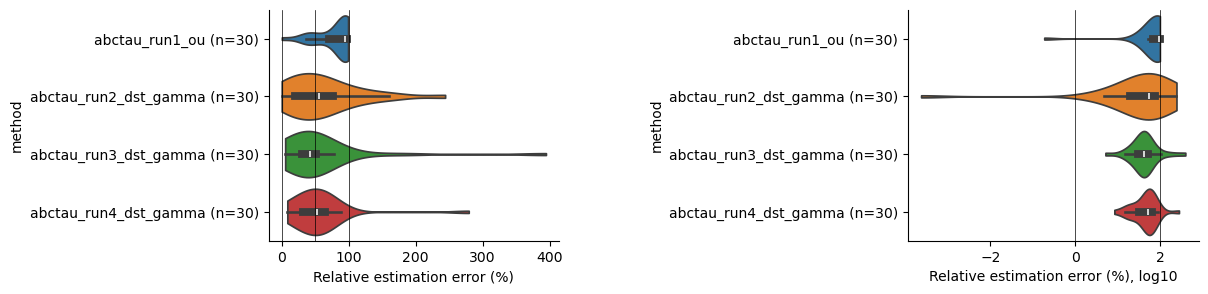

In [20]:
# keep only unit_ids that have all methods present 
counts = df_abctau.groupby('unit_id')['method'].nunique()
complete_units = counts[counts == df_abctau['method'].nunique()].index
df_abctau_complete = df_abctau[df_abctau['unit_id'].isin(complete_units)].copy()
print(f"Remaining units: {len(complete_units)}")
print(f"Filtered DataFrame shape: {df_abctau_complete.shape}")


fig, axes = plt.subplots(1,2, figsize=(12,3))
plt.subplots_adjust(hspace=0.4, wspace=1.2)

method_order = ['abctau_run1_ou', 'abctau_run2_dst_gamma', 'abctau_run3_dst_gamma','abctau_run4_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau_complete , cut=0, ax=axes[0])
axes[0].axvline(x=0, lw=0.5, c='k')
axes[0].axvline(x=50, lw=0.5, c='k')
axes[0].axvline(x=100, lw=0.5, c='k')
axes[0].set_xlabel('Relative estimation error (%)')

df_abctau['tau_diff_rel_log10'] = np.log10(df_abctau['tau_diff_rel'])
method_order = ['abctau_run1_ou', 'abctau_run2_dst_gamma', 'abctau_run3_dst_gamma','abctau_run4_dst_gamma']
sns.violinplot(y='method', x='tau_diff_rel_log10', hue='method', order=method_order, hue_order=method_order, 
               data=df_abctau_complete , cut=0, ax=axes[1])
axes[1].axvline(x=0, lw=0.5, c='k')
axes[1].axvline(x=2, lw=0.5, c='k')
axes[1].set_xlabel('Relative estimation error (%), log10')

for ax in axes.flat:
    sns.despine(ax=ax)
    
axes[0].legend(frameon=False, loc='upper left', bbox_to_anchor=(1.02, 1))

# counts per method (unique units)
counts = (
    df_abctau_complete.groupby('method')['unit_id']
    .nunique()
    .reindex(method_order)       
    .fillna(0).astype(int)
)
labels_with_n = [f"{m} (n={counts.get(m, 0)})" for m in method_order]
axes[0].set_yticklabels(labels_with_n)
axes[1].set_yticklabels(labels_with_n)

if save_fig:
    plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl_matching_units.png' , bbox_inches='tight', dpi=300)
    #plt.savefig(fig_folder + 'parametric_abctau_runs_ree_one_trials_impl_matching_units.svg' , bbox_inches='tight')